In this notebook, we are going to test out how to find the peaks in a time series.

In [36]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import yfinance as yf
import warnings 

warnings.filterwarnings('ignore')

from typing import List, Dict
from dotenv import load_dotenv
from scipy.signal import find_peaks

In [2]:
btc_data = yf.download("BTC-USD", progress=False)

In [3]:
log_close_price = btc_data['Close'].apply(np.log)

In [4]:
price_peaks = find_peaks(
    x = log_close_price,  
    width = 10
)

price_bottoms = find_peaks(
    x = -log_close_price, 
    width = 10
)

In [6]:
peak_indices = price_peaks[0]
bottom_indices = price_bottoms[0]

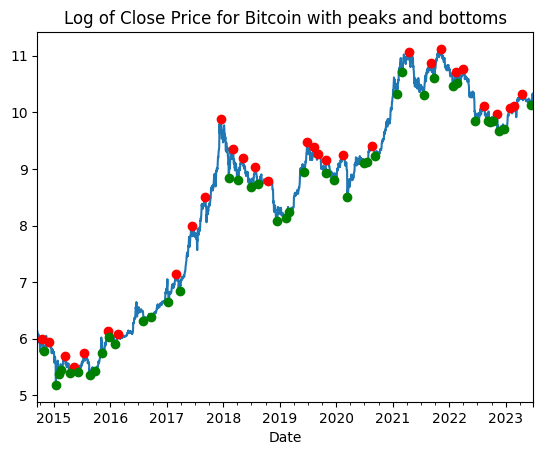

In [8]:
log_close_price.plot()
plt.plot(log_close_price.index[peak_indices], log_close_price[peak_indices], 'ro')
plt.plot(log_close_price.index[bottom_indices], log_close_price[bottom_indices], 'go')
plt.title("Log of Close Price for Bitcoin with peaks and bottoms")
plt.plot()
plt.show()

We see here that we can get some simple peaks and troughs from this data depending on the data points. It would be nice to wrap these into a function which you enter a price series and you get both the peaks and troughs. 

In [25]:
local_max_points = btc_data.iloc[peak_indices, :]
local_min_points = btc_data.iloc[bottom_indices, :]
non_extremum_points = btc_data.drop(local_min_points.index.union(local_max_points.index), axis = 0)

# We then label these and get our new dataframe with labeled data
local_max_points['target'] = -1
local_min_points['target'] = 1
non_extremum_points['target'] = 0

result_df = pd.concat([local_min_points, local_max_points, non_extremum_points], axis = 0).sort_index()

In [34]:
def get_peaks_and_troughs(series: pd.Series, width: int, distance: int) -> Dict[str, np.array]: 
    """Gets peaks and troughs for a time series using the scipy signal find_peaks method. 

    Args:
        series (pd.Series): Price series that you would like peaks and troughs for
        width (int): Width that you'd like for the peak or trough to have
        distance (int): Distance between the successive peaks and troughs. 

    Returns:
        Dict[str, np.array]: A dictionary of the indices for peaks and troughs. 
    """

    neg_series = -series

    peaks = find_peaks(
        x = series, distance=distance, width=width
    )

    troughs = find_peaks(
        x = neg_series, distance=distance, width=width
    )

    return {
        'peaks': peaks[0], 
        'troughs': troughs[0]
    }

def peaks_and_troughs_label(ohlc_dataframe: pd.DataFrame, width: int, distance: int, series_column: str = 'Adj Close') -> pd.Series:

    series = ohlc_dataframe[series_column]

    indices = get_peaks_and_troughs(series=series, width=width, distance=distance)
    
    local_max_points = ohlc_dataframe.iloc[indices['peaks'], :]
    local_min_points = ohlc_dataframe.iloc[indices['troughs'], :]
    non_extremum_points = ohlc_dataframe.drop(local_min_points.index.union(local_max_points.index), axis = 0)

    # We then label these and get our new dataframe with labeled data
    local_max_points['target'] = -1
    local_min_points['target'] = 1
    non_extremum_points['target'] = 0

    result_df = pd.concat([local_min_points, local_max_points, non_extremum_points], axis = 0).sort_index()
    return result_df['target']

    


In [37]:
peaks_and_troughs_label(
    ohlc_dataframe=btc_data, 
    width=10, 
    distance=1, 
    series_column='Adj Close'
)

Date
2014-09-17    0
2014-09-18    0
2014-09-19    0
2014-09-20    0
2014-09-21    0
             ..
2023-06-25    0
2023-06-26    0
2023-06-27    0
2023-06-28    0
2023-06-29    0
Name: target, Length: 3208, dtype: int64

An idea to extend this analysis is to look at the times that we picked out a peak and a trough. Can we train a model to discriminate against one or the other?
If you can train a model to do that, can we use it on new data to see what the relative probabilities are of a point being a "peak" or a "trough". In this way, we get a sense of what the buying zones are and what the "selling" zones are as well. That can be very helpful. 